# Imports

In [67]:
import numpy as np
import pandas as pd
import json
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp
import uncertainties as unc
from datetime import date
import collections

# Functions

In [80]:
def exponential(x, a, b):
    return a * np.exp(b * x)

def exponential2(x, a, b, c):
    return a * np.exp(b*x + c*(x**2))

def weighted_exp_fit(y, cut=8, weights='linear', order=1):
    days = len(y)
    x = np.arange(days)[y > 0]
    y = y[y > 0]
    weights = np.ones(cut) #uniform weights
    if weights == 'linear':
        weights = np.arange(1, cut+1)
    if cut < len(y):
        x = x[len(y)-cut:]
        y = y[len(y)-cut:]
    else:
        weights = weights[len(weights)-len(y):]
    sigma = np.sqrt(y) / weights #linear weights become quadratic as in the least squares method a sigma^2 appears
    if len(y) < 2:
        return [0, 0], [[0, 0], [0, 0]]
    if order == 1:
        popt, pcov = curve_fit(exponential, x, y, sigma=sigma)
    elif order == 2:
        popt, pcov = curve_fit(exponential2, x, y, sigma=sigma)
    return popt, pcov

def initialize_dataframe(categories, default_columns=['data', 'denominazione_regione']):
    columns = default_columns
    for c in range(len(categories)):
        columns.append(categories[c])
        columns.append('std_' + categories[c])
    return pd.DataFrame(columns=columns)

def date_list(today, days=15):
    return pd.date_range(start=today, periods=days, freq='1D')[1:]

In [36]:
oggi = str(date.today())

# Data

In [37]:
df_regions = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')
df_pop = pd.read_csv('dati_regioni.csv')

In [38]:
df_regions.tail()

,codice_regione,data,deceduti,denominazione_regione,dimessi_guariti,isolamento_domiciliare,lat,long,nuovi_attualmente_positivi,ricoverati_con_sintomi,stato,tamponi,terapia_intensiva,totale_attualmente_positivi,totale_casi,totale_ospedalizzati
604,9,2020-03-23 17:00:00,109,Toscana,51,1225,43.769231,11.255889,157,838,ITA,13851,238,2301,2461,1076
605,4,2020-03-23 17:00:00,41,P.A. Trento,68,619,46.068935,11.121231,29,249,ITA,3150,46,914,1023,295
606,10,2020-03-23 17:00:00,16,Umbria,5,408,43.106758,12.388247,56,106,ITA,3561,42,556,577,148
607,2,2020-03-23 17:00:00,12,Valle d'Aosta,2,290,45.737503,7.320149,25,69,ITA,1098,20,379,393,89
608,5,2020-03-23 17:00:00,192,Veneto,327,3499,45.434905,12.338452,342,1206,ITA,61115,281,4986,5505,1487


# Local exponential fit — Italian regions

In [39]:
#creating a new minimalist dataframe
df_temp = df_regions[df_regions.data == max(df_regions.data.values)]
df_temp = df_temp[df_temp.denominazione_regione != '']
df_forecast = df_temp[['data', 'codice_regione', 'denominazione_regione']].copy()
df_forecast['casi_domani'] = 0
df_forecast['std_casi_domani'] = 0
df_forecast['morti_domani'] = 0
df_forecast['std_morti_domani'] = 0
df_forecast['casi_dopodomani'] = 0
df_forecast['std_casi_dopodomani'] = 0
df_forecast['morti_dopodomani'] = 0
df_forecast['std_morti_dopodomani'] = 0

In [40]:
df_forecast.head(1)

,data,codice_regione,denominazione_regione,casi_domani,std_casi_domani,morti_domani,std_morti_domani,casi_dopodomani,std_casi_dopodomani,morti_dopodomani,std_morti_dopodomani
588,2020-03-23 17:00:00,13,Abruzzo,0,0,0,0,0,0,0,0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


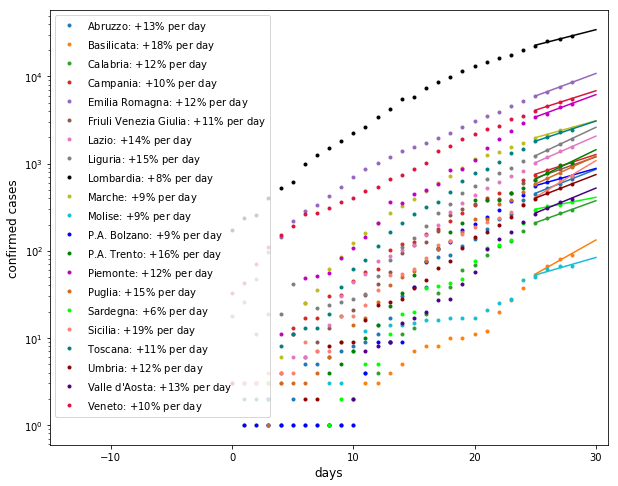

In [41]:
fig, ax = plt.subplots(figsize=(10,8))

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson'] #21 colori per VENTI regioni (mannaggia al Trentino - Alto Adige)

labels = ['casi', 'morti']
for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    for j, y in enumerate((dfr.totale_casi.values, dfr.deceduti.values)):
        days = len(y)
        x = np.arange(days)
        cut = 4
        popt, pcov = weighted_exp_fit(y, cut=cut, weights='linear')
        a, b = unc.correlated_values(popt, pcov)
        slope = unc.nominal_value(b)
        std = unc.std_dev(b)
        xx = np.concatenate((x, [x[-1] + 1, x[-1] + 2])) #extrapolation till the day after tomorrow
        yy = a * unp.exp(b * xx[-3:])
        domani = yy[-2] - yy[-3]
        df_forecast.loc[df_forecast.denominazione_regione == den, labels[j]+'_domani'] = np.round(domani.nominal_value)
        df_forecast.loc[df_forecast.denominazione_regione == den, 'std_'+labels[j]+'_domani'] = np.round(domani.std_dev)
        dopodomani = yy[-1] - yy[-2]
        df_forecast.loc[df_forecast.denominazione_regione == den, labels[j]+'_dopodomani'] = np.round(dopodomani.nominal_value)
        df_forecast.loc[df_forecast.denominazione_regione == den, 'std_'+labels[j]+'_dopodomani'] = np.round(dopodomani.std_dev)
        
        if j == 0: #plot
            label = '{}: $+${}% per day'.format(den, int(round(slope, 2)*100))
            ax.plot(xx[days-cut:], exponential(xx[days-cut:], *popt), color=colors[i])
            ax.plot(x[y>0], y[y>0], '.', color=colors[i], label=label)
    
ax.set_yscale('log')
ax.set_ylabel('confirmed cases', fontsize='large')
ax.set_xlabel('days', fontsize='large')
ax.set_xlim(-15, days+2)
ax.legend(loc=0)

fig.savefig('plot/{}-Alberto-LocalExp-regions.png'.format(oggi), dpi = 300)

In [42]:
data_oggi = max(df_forecast.data)[:10]
df_forecast.to_csv('LocalExp_forecast_regioni_{}.csv'.format(data_oggi))

## Fit of several categories

In [91]:
categories = ['totale_casi', 'terapia_intensiva', 'deceduti']

output = collections.defaultdict(list)
lastdate = df_regions['data'].max()
futuredates = pd.date_range(start=lastdate, periods=15, freq='1D')[1:]

In [92]:
for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    output['denominazione_regione'] += [den] * len(futuredates)
    output['data'] += list(futuredates)
    for j, category in enumerate(categories):
        y = dfr[category].values
        days = len(y)
        x = np.arange(days)
        cut = 8
        popt, pcov = weighted_exp_fit(y, cut=cut, weights='linear')
        xx = np.arange(days, days + len(futuredates))
        yy = a * unp.exp(b * xx)
        output[category] += list(unp.nominal_values(yy))
        output['std_' + category] += list(unp.std_devs(yy))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


In [99]:
df_predictions = pd.DataFrame(output)

directory = f'../predictions/{lastdate[:10]}/dati-regioni'
path = f'{directory}/model-LocalExp-order1.csv'
df_predictions.to_csv(path, index=False)